# INSTRUCTIONS

#### Part 1: Computing the optimal speed from the optimal racing line
- Part 1 of this notebook takes the optimal racing line, which can be generated with Race-Line-Calculation.ipynb ([GitHub](https://github.com/cdthompson/deepracer-k1999-race-lines)), and generates the optimal speed for each point on the racing line
- Input: .py file with 2D array containing optimal racing line: 2 columns (x,y)
- Output: .py file with 2D array: 4 columns (x,y,speed,expected time). This array can be inserted into the reward function
- Note: The last point of the racing line is deleted because it is the same point as the first one

#### Part 2: Computing the Action Space
- Part 2 of this notebook takes the optimal racing line and speed, and uses K-Means with Gaussian Noise infused data, to calculate the action space

In [4]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import stats
import math
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

# Ignore deprecation warnings we have no power over
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Path of the optimal racing line (.npy file)
fpath = "./racelines/Monaco-1500-4-2020-11-30-215016.npy"

# Change manually (this is only so that output files are named correctly)
TRACK_NAME = "Monaco"

racing_track_np = np.load(fpath)
# Convert np array to list and remove last point because it is the same point as the first one
racing_track = racing_track_np.tolist()[:-1]

# Load the center, inner, outer waypoints
waypoints = np.load("./tracks/%s.npy" % TRACK_NAME)

# Convert to Shapely objects
center_line = waypoints[:,0:2]
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]
l_center_line = LineString(center_line)
l_inner_border = LineString(inner_border)
l_outer_border = LineString(outer_border)
road_poly = Polygon(np.vstack((l_outer_border, np.flipud(l_inner_border))))

racing_track_np 

array([[-7.17590742,  0.52298408],
       [-7.04788787,  0.77609672],
       [-6.91385804,  1.01895845],
       [-6.77416419,  1.2507485 ],
       [-6.62874266,  1.46985389],
       [-6.47766998,  1.67489662],
       [-6.32089709,  1.86421896],
       [-6.15827754,  2.03599652],
       [-5.98951994,  2.18823711],
       [-5.8138379 ,  2.31794788],
       [-5.62990697,  2.42180911],
       [-5.43478567,  2.49528053],
       [-5.23089034,  2.54880969],
       [-5.01847437,  2.58525637],
       [-4.79764439,  2.60660457],
       [-4.56814522,  2.61396564],
       [-4.32967384,  2.60833409],
       [-4.08205465,  2.59085307],
       [-3.82492414,  2.56241425],
       [-3.55822525,  2.52422963],
       [-3.28202188,  2.47751769],
       [-2.99641659,  2.42339922],
       [-2.70174421,  2.36303735],
       [-2.39865608,  2.29764926],
       [-2.08831496,  2.22854694],
       [-1.77317028,  2.15733374],
       [-1.45570155,  2.08646628],
       [-1.14181555,  2.01896871],
       [-0.83483082,

# Helper functions for Part 1 and Part 2

In [6]:
# Uses previous and next coords to calculate the radius of the curve
# so you need to pass a list with form [[x1,y1],[x2,y2],[x3,y3]]
# Input 3 coords [[x1,y1],[x2,y2],[x3,y3]]
def circle_radius(coords):

    # Flatten the list and assign to variables (makes code easier to read later)
    x1, y1, x2, y2, x3, y3 = [i for sub in coords for i in sub]

    a = x1*(y2-y3) - y1*(x2-x3) + x2*y3 - x3*y2
    b = (x1**2+y1**2)*(y3-y2) + (x2**2+y2**2)*(y1-y3) + (x3**2+y3**2)*(y2-y1)
    c = (x1**2+y1**2)*(x2-x3) + (x2**2+y2**2)*(x3-x1) + (x3**2+y3**2)*(x1-x2)
    d = (x1**2+y1**2)*(x3*y2-x2*y3) + (x2**2+y2**2) * \
        (x1*y3-x3*y1) + (x3**2+y3**2)*(x2*y1-x1*y2)

    # In case a is zero (so radius is infinity)
    try:
        r = abs((b**2+c**2-4*a*d) / abs(4*a**2)) ** 0.5
    except:
        r = 999

    return r


# Returns indexes of next index and index+lookfront
# We need this to calculate the radius for next track section.
def circle_indexes(mylist, index_car, add_index_1=0, add_index_2=0):

    list_len = len(mylist)

    # if index >= list_len:
    #     raise ValueError("Index out of range in circle_indexes()")

    # Use modulo to consider that track is cyclical
    index_1 = (index_car + add_index_1) % list_len
    index_2 = (index_car + add_index_2) % list_len

    return [index_car, index_1, index_2]


def optimal_velocity(track, min_speed, max_speed, look_ahead_points):

    # Calculate the radius for every point of the track
    radius = []
    for i in range(len(track)):
        indexes = circle_indexes(track, i, add_index_1=-1, add_index_2=1)
        coords = [track[indexes[0]],
                  track[indexes[1]], track[indexes[2]]]
        radius.append(circle_radius(coords))

    # Get the max_velocity for the smallest radius
    # That value should multiplied by a constant multiple
    v_min_r = min(radius)**0.5
    constant_multiple = min_speed / v_min_r
    print(f"Constant multiple for optimal speed: {constant_multiple}")

    if look_ahead_points == 0:
        # Get the maximal velocity from radius
        max_velocity = [(constant_multiple * i**0.5) for i in radius]
        # Get velocity from max_velocity (cap at MAX_SPEED)
        velocity = [min(v, max_speed) for v in max_velocity]
        return velocity

    else:
        # Looks at the next n radii of points and takes the minimum
        # goal: reduce lookahead until car crashes bc no time to break
        LOOK_AHEAD_POINTS = look_ahead_points
        radius_lookahead = []
        for i in range(len(radius)):
            next_n_radius = []
            for j in range(LOOK_AHEAD_POINTS+1):
                index = circle_indexes(
                    mylist=radius, index_car=i, add_index_1=j)[1]
                next_n_radius.append(radius[index])
            radius_lookahead.append(min(next_n_radius))
        max_velocity_lookahead = [(constant_multiple * i**0.5)
                                  for i in radius_lookahead]
        velocity_lookahead = [min(v, max_speed)
                              for v in max_velocity_lookahead]
        return velocity_lookahead


# For each point in racing track, check if left curve (returns boolean)
def is_left_curve(coords):

    # Flatten the list and assign to variables (makes code easier to read later)
    x1, y1, x2, y2, x3, y3 = [i for sub in coords for i in sub]

    return ((x2-x1)*(y3-y1) - (y2-y1)*(x3-x1)) > 0


# Calculate the distance between 2 points
def dist_2_points(x1, x2, y1, y2):
        return abs(abs(x1-x2)**2 + abs(y1-y2)**2)**0.5

# Part 1: Calculate optimal speed

- Change ```LOOK_AHEAD_POINTS``` to influence how many points the algorithm looks ahead (the higher, the sooner the car will start to break)
- Change ```MIN_SPEED``` and ```MAX_SPEED``` to fit the track and model !

In [16]:
LOOK_AHEAD_POINTS = 5

MIN_SPEED = 1.2
MAX_SPEED = 3.6

# Calculate optimal speed
velocity = optimal_velocity(track=racing_track, 
    min_speed=MIN_SPEED, max_speed=MAX_SPEED, look_ahead_points=LOOK_AHEAD_POINTS)

Constant multiple for optimal speed: 1.6602695166824617


## Visualization

Constant multiple for optimal speed: 1.6602695166824617


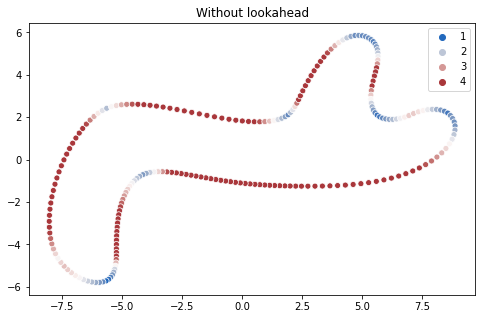

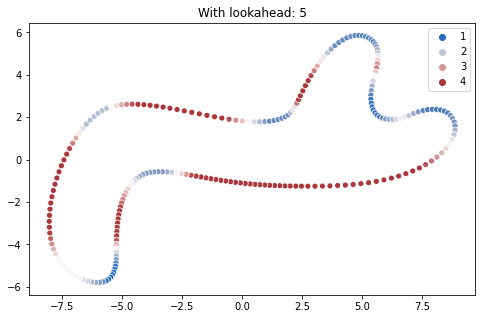

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns

x = [i[0] for i in racing_track]
y = [i[1] for i in racing_track]

# Without lookahead
velocity_no_lookahead = optimal_velocity(track=racing_track,
    min_speed=MIN_SPEED, max_speed=MAX_SPEED, look_ahead_points=0)

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.scatterplot(x=x, y=y, hue=velocity_no_lookahead,
                     palette="vlag").set_title("Without lookahead")

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.scatterplot(x=x, y=y, hue=velocity, palette="vlag").set_title(
    f"With lookahead: {LOOK_AHEAD_POINTS}")

#### Calculate distance and optimal time between each racing point

In [18]:
distance_to_prev = []
for i in range(len(racing_track)):
    indexes = circle_indexes(racing_track, i, add_index_1=-1, add_index_2=0)[0:2]
    coords = [racing_track[indexes[0]],racing_track[indexes[1]]]
    dist_to_prev = dist_2_points(x1=coords[0][0], x2=coords[1][0], y1=coords[0][1], y2=coords[1][1])
    distance_to_prev.append(dist_to_prev)
    
time_to_prev = [(distance_to_prev[i]/velocity[i]) for i in range(len(racing_track))]

total_time = sum(time_to_prev)
print(f"Total time for track, if racing line and speeds are followed perfectly: {total_time} s")

Total time for track, if racing line and speeds are followed perfectly: 21.128200757848216 s


## Append everything together and save to .txt file

In [7]:
# Own code: Reduce width of track
def plot_points(ax, points):
    ax.scatter(points[:-1,0], points[:-1,1], s=1)
    for i,p in enumerate(points):
        if i % 5 == 0:
            ax.annotate(i, (p[0], p[1]))
        #else:
            #ax.annotate('*', (p[0], p[1]), color=color)

def dist_2_points(x1, x2, y1, y2):
        return abs(abs(x1-x2)**2 + abs(y1-y2)**2)**0.5
    
def x_perc_width(waypoint, perc_width):
    
    center_x, center_y, inner_x, inner_y, outer_x, outer_y = waypoint
    
    width = dist_2_points(inner_x, outer_x, inner_y, outer_y)
    
    delta_x = outer_x-inner_x
    delta_y = outer_y-inner_y
    
    inner_x_new = inner_x + delta_x/2 * (1-perc_width)
    outer_x_new = outer_x - delta_x/2 * (1-perc_width)
    inner_y_new = inner_y + delta_y/2 * (1-perc_width)
    outer_y_new = outer_y - delta_y/2 * (1-perc_width)
    
    return [center_x, center_y, inner_x_new, inner_y_new, outer_x_new, outer_y_new]

PERC_WIDTH = 0.6
waypoints_new = [x_perc_width(waypoint, perc_width=PERC_WIDTH) for waypoint in waypoints]
waypoints_new = np.asarray(waypoints_new)

# Convert to Shapely objects
inner_border_new = waypoints_new[:,2:4]
outer_border_new = waypoints_new[:,4:6]
l_inner_border_new = LineString(inner_border_new)
l_outer_border_new = LineString(outer_border_new)
road_poly_new = Polygon(np.vstack((l_outer_border_new, np.flipud(l_inner_border_new))))


In [8]:
o1 = [[-0.9305498412456339, 2.3051788068776062], [5.399832815944913, 3.104284174765702], [8.280002086529988, 0.23923803569347463], [-4.713253533598179, -4.476735443873611], [-7.950431461871854, -2.291442843326418], [-8.126428022680763, -0.1620472316206611]]
o2 = [[-2.1153138802432125, 1.8160167619673613], [2.718974367693935, 3.094191020462276], [8.174953489154456, 0.16776473219667581], [3.9809893369674683, -1.0426595509052277], [0.8595635843877878, -0.7425004210392467], [-7.909992495634366, -4.644495193936562]]
o3 = [[-2.6194274021001984, 2.68579989819489], [4.778987375069798, 1.7566788064322953], [6.39663531127952, -0.8447661266540276], [4.408292839007304, -1.6749506330925614], [-2.3074679847013195, -0.08557719899903832], [-7.028792931289656, -6.249249194632359]]
o4 = [[-5.574565204895726, 3.405997408219287], [-2.1374467178790506, 2.5670382838495476], [8.949872186713627, 3.0555026516531143], [1.8909664297540774, -0.8229302472704961], [-8.70168616656893, -3.179981279592988], [-7.63826415530781, -0.9310726330007029]]
o5 = [[-2.0144717154513905, 1.7912805838431458], [2.715659302284803, 3.1074760364868252], [5.747983684367263, 1.071643430090489], [9.602943246429202, 0.6550952457486463], [-5.1925239035057125, -2.8975457038984405], [-7.691212643061788, -1.1047994731342634]]
o6 = [[2.2224397579969795, 2.4413621231264204], [6.636140628593448, 2.194698623213558], [8.628855228424072, 2.416707754135132], [-0.5649714265462619, -1.1428686641219392], [-3.931066882203001, -0.4188390120911268], [-7.8919423915339175, -1.9362760482982397]]
o7 = [[0.4814889982367836, 2.077884315481076], [4.435441209197361, 5.995586420832673], [6.739428555863852, -1.5024813964707762], [1.1208485520240274, -0.716576281864423], [-5.697766932058165, -2.255076054630529], [-8.471180621870259, -1.2104134195949965]]
o8 = [[-4.024127534170848, 3.0428563379571183], [5.796018210931006, 5.130560113369234], [5.401798963546753, 3.1142547726631165], [-5.266320858764739, -3.247209663470102], [-5.248357804466667, -5.495060053354274], [-7.990723740530145, -4.273559305390448]]


racing_track1 = [[-7.17591, 0.52298, 4.10878, 0.07042],
                        [-7.04789, 0.7761, 3.81443, 0.07436],
                        [-6.91386, 1.01896, 3.49017, 0.07948],
                        [-6.77416, 1.25075, 3.16465, 0.08552],
                        [-6.62874, 1.46985, 2.8488, 0.09231],
                        [-6.47767, 1.6749, 2.50403, 0.10171],
                        [-6.3209, 1.86422, 2.20418, 0.11152],
                        [-6.15828, 2.036, 1.93961, 0.12195],
                        [-5.98952, 2.18824, 1.93961, 0.11718],
                        [-5.81384, 2.31795, 1.93961, 0.11259],
                        [-5.62991, 2.42181, 1.93961, 0.1089],
                        [-5.43479, 2.49528, 2.36482, 0.08817],
                        [-5.23089, 2.54881, 2.60203, 0.08102],
                        [-5.01847, 2.58526, 2.86312, 0.07527],
                        [-4.79764, 2.6066, 3.11086, 0.07132],
                        [-4.56815, 2.61397, 3.40455, 0.06744],
                        [-4.32967, 2.60833, 3.7836, 0.06305],
                        [-4.08205, 2.59085, 4.19665, 0.05915],
                        [-3.82492, 2.56241, 4.76526, 0.05429],
                        [-3.55823, 2.52423, 5.46855, 0.04927],
                        [-3.28202, 2.47752, 6.3146, 0.04436],
                        [-2.99642, 2.4234, 7.42618, 0.03914],
                        [-2.70174, 2.36304, 8.0, 0.0376],
                        [-2.39866, 2.29765, 8.0, 0.03876],
                        [-2.08831, 2.22855, 8.0, 0.03974],
                        [-1.77317, 2.15733, 6.83261, 0.04729],
                        [-1.4557, 2.08647, 5.89314, 0.0552],
                        [-1.14182, 2.01897, 5.18713, 0.0619],
                        [-0.83483, 1.95714, 4.62665, 0.06768],
                        [-0.53778, 1.9029, 4.15058, 0.07275],
                        [-0.25308, 1.85778, 3.74419, 0.07699],
                        [0.01774, 1.82281, 3.43633, 0.07946],
                        [0.2739, 1.79859, 3.05477, 0.08423],
                        [0.51516, 1.78546, 2.73865, 0.08823],
                        [0.74168, 1.78358, 2.41331, 0.09386],
                        [0.95413, 1.79271, 2.14151, 0.0993],
                        [1.15237, 1.81335, 1.90867, 0.10442],
                        [1.3365, 1.84587, 1.69546, 0.11028],
                        [1.50616, 1.89112, 1.48929, 0.11791],
                        [1.6611, 1.95001, 1.48929, 0.11129],
                        [1.80084, 2.0238, 1.48929, 0.10611],
                        [1.92424, 2.11477, 1.48929, 0.10294],
                        [2.02878, 2.22832, 1.91298, 0.08068],
                        [2.12242, 2.35792, 2.20883, 0.07238],
                        [2.20774, 2.50253, 2.59829, 0.06462],
                        [2.2868, 2.66107, 3.207, 0.05524],
                        [2.36154, 2.8312, 4.54254, 0.04091],
                        [2.43403, 3.00817, 5.50102, 0.03476],
                        [2.53618, 3.2458, 5.23377, 0.04942],
                        [2.64502, 3.48503, 4.91468, 0.05348],
                        [2.75998, 3.72341, 4.6009, 0.05752],
                        [2.88068, 3.95899, 4.22075, 0.06271],
                        [3.0069, 4.19, 3.86756, 0.06806],
                        [3.13848, 4.41461, 3.48139, 0.07478],
                        [3.27526, 4.63107, 3.15132, 0.08125],
                        [3.41721, 4.83734, 2.83413, 0.08835],
                        [3.56425, 5.03148, 2.53072, 0.09623],
                        [3.71646, 5.21119, 2.24385, 0.10496],
                        [3.87372, 5.37439, 2.01288, 0.1126],
                        [4.03579, 5.51877, 1.75692, 0.12354],
                        [4.20206, 5.64167, 1.53013, 0.13513],
                        [4.37133, 5.74002, 1.53013, 0.12794],
                        [4.54149, 5.81132, 1.48211, 0.12448],
                        [4.70906, 5.85186, 1.48211, 0.11632],
                        [4.86822, 5.8585, 1.48211, 0.10748],
                        [5.01683, 5.84004, 1.47072, 0.10182],
                        [5.15165, 5.79737, 1.40511, 0.10064],
                        [5.27312, 5.73579, 1.40511, 0.09692],
                        [5.38056, 5.65709, 1.40511, 0.09478],
                        [5.47266, 5.56196, 1.40511, 0.09424],
                        [5.5466, 5.44974, 1.49016, 0.09018],
                        [5.60237, 5.32241, 1.6588, 0.0838],
                        [5.64118, 5.18225, 1.82616, 0.07964],
                        [5.66358, 5.03056, 2.01705, 0.07602],
                        [5.67001, 4.8683, 2.28004, 0.07122],
                        [5.66159, 4.69663, 2.64575, 0.06496],
                        [5.6402, 4.517, 3.03562, 0.05959],
                        [5.60743, 4.33049, 3.61434, 0.05239],
                        [5.56559, 4.13852, 3.64861, 0.05385],
                        [5.51715, 3.94258, 3.11056, 0.06489],
                        [5.46384, 3.70634, 2.69764, 0.08978],
                        [5.4197, 3.47608, 2.37879, 0.09856],
                        [5.38802, 3.25428, 2.10831, 0.10627],
                        [5.37113, 3.04311, 1.86234, 0.11375],
                        [5.37072, 2.84455, 1.66132, 0.11952],
                        [5.38761, 2.66027, 1.45706, 0.127],
                        [5.42214, 2.49182, 1.28996, 0.13331],
                        [5.4745, 2.34094, 1.28996, 0.12381],
                        [5.54445, 2.2093, 1.28996, 0.11556],
                        [5.63234, 2.09985, 1.28996, 0.10882],
                        [5.73847, 2.01652, 1.3402, 0.10069],
                        [5.85902, 1.957, 1.4714, 0.09137],
                        [5.99085, 1.91832, 1.61931, 0.08485],
                        [6.1321, 1.8987, 1.74845, 0.08156],
                        [6.28182, 1.89778, 1.91119, 0.07834],
                        [6.43919, 1.91519, 2.10787, 0.07511],
                        [6.60358, 1.95048, 2.298, 0.07317],
                        [6.77507, 2.00395, 2.4763, 0.07254],
                        [6.95492, 2.0771, 2.45452, 0.0791],
                        [7.14736, 2.17367, 2.25292, 0.09557],
                        [7.34749, 2.25428, 2.03202, 0.10618],
                        [7.54488, 2.31427, 1.83139, 0.11265],
                        [7.73813, 2.35398, 1.64136, 0.1202],
                        [7.9258, 2.3724, 1.47173, 0.12813],
                        [8.10596, 2.36784, 1.32694, 0.13582],
                        [8.27617, 2.33854, 1.32694, 0.13016],
                        [8.43304, 2.28228, 1.32694, 0.12559],
                        [8.57166, 2.19643, 1.32694, 0.12288],
                        [8.68431, 2.0779, 1.56327, 0.1046],
                        [8.77518, 1.93743, 1.56327, 0.10702],
                        [8.84207, 1.77658, 1.56327, 0.11143],
                        [8.8773, 1.59414, 1.59525, 0.11648],
                        [8.87339, 1.39265, 1.84129, 0.10945],
                        [8.83254, 1.17983, 2.01489, 0.10755],
                        [8.75471, 0.96127, 2.23356, 0.10387],
                        [8.6422, 0.74215, 2.425, 0.10157],
                        [8.49708, 0.52682, 2.62189, 0.09904],
                        [8.32213, 0.31895, 2.8251, 0.09617],
                        [8.12063, 0.12139, 3.03366, 0.09302],
                        [7.89604, -0.06383, 3.24563, 0.0897],
                        [7.65175, -0.23546, 3.4309, 0.08702],
                        [7.39064, -0.39262, 3.60578, 0.08452],
                        [7.11526, -0.53481, 3.7805, 0.08198],
                        [6.82795, -0.66189, 3.9602, 0.07933],
                        [6.53081, -0.77404, 4.14891, 0.07655],
                        [6.22574, -0.87171, 4.35086, 0.07362],
                        [5.91436, -0.95555, 4.57102, 0.07055],
                        [5.59812, -1.02639, 4.8155, 0.0673],
                        [5.27826, -1.08518, 5.09172, 0.06387],
                        [4.95592, -1.13296, 5.4083, 0.06025],
                        [4.63224, -1.17083, 5.77466, 0.05643],
                        [4.30846, -1.1999, 6.20099, 0.05243],
                        [3.986, -1.22131, 6.7015, 0.04822],
                        [3.66655, -1.2362, 7.30639, 0.04377],
                        [3.35186, -1.24571, 8.0, 0.03935],
                        [3.04377, -1.25096, 8.0, 0.03852],
                        [2.74802, -1.25268, 8.0, 0.03697],
                        [2.48052, -1.25163, 8.0, 0.03344],
                        [2.23813, -1.24859, 8.0, 0.0303],
                        [2.00959, -1.24395, 8.0, 0.02857],
                        [1.78954, -1.2378, 7.71049, 0.02855],
                        [1.57532, -1.23007, 7.40634, 0.02894],
                        [1.36497, -1.22073, 7.20165, 0.02924],
                        [1.15735, -1.20966, 6.90551, 0.03011],
                        [0.95165, -1.19671, 6.74149, 0.03057],
                        [0.74727, -1.18172, 6.67016, 0.03072],
                        [0.54371, -1.16457, 6.67016, 0.03063],
                        [0.34063, -1.14504, 6.67016, 0.03059],
                        [0.13772, -1.12298, 6.67016, 0.0306],
                        [-0.06528, -1.09832, 6.6858, 0.03059],
                        [-0.26855, -1.07101, 6.79102, 0.0302],
                        [-0.47224, -1.04109, 6.99479, 0.02943],
                        [-0.67644, -1.00867, 7.31645, 0.02826],
                        [-0.88118, -0.97393, 7.7937, 0.02665],
                        [-1.08646, -0.93709, 8.0, 0.02607],
                        [-1.29226, -0.89846, 8.0, 0.02617],
                        [-1.49848, -0.85839, 8.0, 0.02626],
                        [-1.70505, -0.81724, 6.72891, 0.0313],
                        [-1.91184, -0.7754, 5.55174, 0.038],
                        [-2.11836, -0.73396, 4.62043, 0.04559],
                        [-2.32397, -0.69418, 3.97078, 0.05274],
                        [-2.5279, -0.65741, 3.46622, 0.05978],
                        [-2.7294, -0.62488, 3.01372, 0.06773],
                        [-2.92751, -0.59819, 2.65043, 0.07542],
                        [-3.12121, -0.57886, 2.32453, 0.08374],
                        [-3.30948, -0.5684, 2.03364, 0.09272],
                        [-3.49116, -0.56853, 1.78014, 0.10206],
                        [-3.66515, -0.58083, 1.64316, 0.10616],
                        [-3.83023, -0.60709, 1.64316, 0.10173],
                        [-3.98492, -0.64939, 1.64316, 0.09759],
                        [-4.12732, -0.7103, 1.64316, 0.09426],
                        [-4.25618, -0.79128, 1.81361, 0.08391],
                        [-4.37392, -0.88823, 1.98955, 0.07666],
                        [-4.482, -0.99858, 2.15293, 0.07175],
                        [-4.58124, -1.12073, 2.31599, 0.06795],
                        [-4.67215, -1.25348, 2.47519, 0.065],
                        [-4.75505, -1.3959, 2.65954, 0.06196],
                        [-4.83033, -1.54702, 2.80586, 0.06017],
                        [-4.89806, -1.70622, 2.96357, 0.05838],
                        [-4.95839, -1.87285, 3.13487, 0.05653],
                        [-5.01146, -2.04625, 3.32059, 0.05461],
                        [-5.05751, -2.22569, 3.52189, 0.0526],
                        [-5.09682, -2.41046, 3.74228, 0.05048],
                        [-5.12974, -2.59984, 3.99044, 0.04817],
                        [-5.15671, -2.79312, 4.28302, 0.04557],
                        [-5.17823, -2.98964, 4.64736, 0.04254],
                        [-5.19493, -3.18876, 5.12188, 0.03901],
                        [-5.20754, -3.38989, 5.74101, 0.0351],
                        [-5.21681, -3.59254, 6.1789, 0.03283],
                        [-5.22314, -3.79641, 5.89755, 0.03459],
                        [-5.22685, -4.00128, 4.1587, 0.04927],
                        [-5.22814, -4.20699, 3.36703, 0.0611],
                        [-5.2274, -4.37682, 2.80195, 0.06061],
                        [-5.22892, -4.54471, 2.40416, 0.06984],
                        [-5.23476, -4.70899, 2.10874, 0.07796],
                        [-5.24673, -4.86836, 1.84661, 0.08655],
                        [-5.26677, -5.02152, 1.61153, 0.09585],
                        [-5.29668, -5.16722, 1.42417, 0.10444],
                        [-5.33799, -5.3042, 1.24246, 0.11515],
                        [-5.39244, -5.4307, 1.2, 0.11477],
                        [-5.46213, -5.54426, 1.2, 0.11103],
                        [-5.54926, -5.64164, 1.2, 0.10889],
                        [-5.6575, -5.71665, 1.2, 0.10975],
                        [-5.78742, -5.76364, 1.48513, 0.09302],
                        [-5.93125, -5.78823, 1.62931, 0.08956],
                        [-6.08651, -5.79021, 1.77517, 0.08747],
                        [-6.25071, -5.76913, 1.93106, 0.08572],
                        [-6.42095, -5.72495, 2.08121, 0.08451],
                        [-6.59409, -5.65799, 2.21302, 0.08389],
                        [-6.76689, -5.56889, 2.35902, 0.08241],
                        [-6.93636, -5.45926, 2.48488, 0.08123],
                        [-7.10009, -5.33067, 2.59893, 0.08011],
                        [-7.2562, -5.18468, 2.34732, 0.09106],
                        [-7.40306, -5.02242, 2.34732, 0.09323],
                        [-7.53934, -4.845, 2.34732, 0.09531],
                        [-7.66207, -4.65143, 2.34732, 0.09764],
                        [-7.76462, -4.43833, 2.63065, 0.0899],
                        [-7.84869, -4.21013, 2.85448, 0.0852],
                        [-7.91526, -3.9691, 3.07747, 0.08125],
                        [-7.96524, -3.71701, 3.30398, 0.07779],
                        [-7.99943, -3.45528, 3.55091, 0.07433],
                        [-8.01875, -3.18528, 3.76353, 0.07192],
                        [-8.02378, -2.90811, 3.97412, 0.06976],
                        [-8.01506, -2.62485, 4.18239, 0.06776],
                        [-7.99314, -2.33663, 4.38208, 0.06596],
                        [-7.9586, -2.04463, 4.56561, 0.0644],
                        [-7.912, -1.7501, 4.72417, 0.06312],
                        [-7.85391, -1.45438, 4.84819, 0.06216],
                        [-7.78492, -1.15893, 4.92981, 0.06154],
                        [-7.70559, -0.8653, 4.90582, 0.062],
                        [-7.61652, -0.57508, 4.83243, 0.06282],
                        [-7.51834, -0.28982, 4.75845, 0.0634],
                        [-7.41177, -0.0109, 4.63329, 0.06444],
                        [-7.29742, 0.26039, 4.45259, 0.06612]]

In [57]:
racing_track = np.asarray(racing_track)

objects_location = o2
track_width = 1.429430688666655

track_length = 60.26571885716431
max_step = len(racing_track)
step_length = track_length / max_step

track_width_half = track_width / 2
object_lookahead = 4
object_threshold = object_lookahead * track_width_half
object_threshold_step_number = object_threshold / step_length

print('step_length', step_length)

print('track_width_half', track_width_half)
print('object_threshold', object_threshold)
print('object_threshold_step_number', object_threshold_step_number)

objects_waypoint_index = []
objects_lookahead_waypoint_index1 = []
objects_lookahead_waypoint_index2 = []

def dist_2_points(x1, x2, y1, y2):
    return abs(abs(x1-x2)**2 + abs(y1-y2)**2)**0.5

def indexes_cyclical(point, diff, array_len):
    next_point = point + diff
    if point + diff >= array_len:
        next_point = point + diff - array_len
    elif point + diff < 0:
        next_point = point + diff + array_len
    return next_point

def indexes_diff_cyclical(point1, point2, array_len):
    diff = point2 - point1
    print('indexes_diff_cyclical ', point1, point2, array_len)
    print('diff1 ', diff)
    if diff < 0:
        diff = array_len + diff
        print('diff2 ', diff)
    if diff > array_len * 0.3:
        diff = array_len - diff
        print('diff3 ', diff)
    return diff

#print(indexes_cyclical(1,-2,100))
print(indexes_diff_cyclical(20,19,100))

for i in range(len(objects_location)):
    distances = []
    for j in range(len(racing_track)):
        distance = dist_2_points(x1=racing_track[j][0], x2=objects_location[i][0],
                             y1=racing_track[j][1], y2=objects_location[i][1])
        distances.append(distance)
    obstacle_index = distances.index(min(distances))
    objects_waypoint_index.append(obstacle_index)
    objects_lookahead_waypoint_index1.append(indexes_cyclical(obstacle_index, -10, len(racing_track)))
    objects_lookahead_waypoint_index2.append(-1)
    
print(objects_waypoint_index)
print(objects_lookahead_waypoint_index1)
print(objects_lookahead_waypoint_index2)

step_length 0.2575458070818988
track_width_half 0.7147153443333275
object_threshold 2.85886137733331
object_threshold_step_number 11.100399613278118
indexes_diff_cyclical  20 19 100
diff1  -1
diff2  99
diff3  1
1
[24, 48, 118, 132, 145, 215]
[14, 38, 108, 122, 135, 205]
[-1, -1, -1, -1, -1, -1]


In [58]:
racing_track_new = []

for i in range(len(racing_track)):
    distances = []
    for j in range(len(objects_location)):
        distance = dist_2_points(x1=racing_track[i][0], x2=objects_location[j][0],
                             y1=racing_track[i][1], y2=objects_location[j][1])
        distances.append(distance)

    if min(distances) <= object_threshold:
        object_index = distances.index(min(distances))
        object_waypoint_index = objects_waypoint_index[object_index]
        waypont_len_to_object = indexes_diff_cyclical(i, object_waypoint_index, len(racing_track))
        print('waypont_len_to_object', waypont_len_to_object)
        if objects_lookahead_waypoint_index2[object_index] == -1 and waypont_len_to_object <=object_threshold_step_number:
            objects_lookahead_waypoint_index2[object_index] = i

for i in range(len(racing_track)):
    distances = []
    for j in range(len(objects_location)):
        distance = dist_2_points(x1=racing_track[i][0], x2=objects_location[j][0],
                             y1=racing_track[i][1], y2=objects_location[j][1])
        distances.append(distance)

    if min(distances) <= object_threshold:
        object_index = distances.index(min(distances))
        object_waypoint_index = objects_waypoint_index[object_index]
        #if objects_lookahead_waypoint_index2[object_index] == -1:
        #    objects_lookahead_waypoint_index2[object_index] = i
        waypont_len_to_object = indexes_diff_cyclical(objects_lookahead_waypoint_index2[object_index], object_waypoint_index, len(racing_track))

        if waypont_len_to_object > 20:
            racing_track_new.append([racing_track[i][0], racing_track[i][1]])
        else:
            print('idx', i, 'object_waypoint_index', object_waypoint_index, waypont_len_to_object, object_index, len(racing_track))
            perc_width = min(1.0, indexes_diff_cyclical(i, object_waypoint_index, len(racing_track)) / waypont_len_to_object)
            print('perc_old', perc_width)
            #perc_width = 2 * perc_width - perc_width * perc_width
            perc_width = perc_width * perc_width
            print('perc_new', perc_width)


            #print(obstacle_index)
            distance_innerborder = dist_2_points(x1=inner_border_new[object_waypoint_index][0], x2=objects_location[object_index][0],
                                 y1=inner_border_new[object_waypoint_index][1], y2=objects_location[object_index][1])

            distance_outerborder = dist_2_points(x1=outer_border_new[object_waypoint_index][0], x2=objects_location[object_index][0],
                                 y1=outer_border_new[object_waypoint_index][1], y2=objects_location[object_index][1])

            if distance_innerborder > distance_outerborder:
                width = dist_2_points(x1=racing_track[i][0], x2=inner_border_new[i][0],
                                     y1=racing_track[i][1], y2=inner_border_new[i][1])

                delta_x = racing_track[i][0]-inner_border_new[i][0]
                delta_y = racing_track[i][1]-inner_border_new[i][1]

                racing_x_new = inner_border_new[i][0] + delta_x * (perc_width)
                racing_y_new = inner_border_new[i][1] + delta_y * (perc_width)

                racing_track_new.append([racing_x_new, racing_y_new])
            else:
                width = dist_2_points(x1=racing_track[i][0], x2=outer_border_new[i][0],
                                     y1=racing_track[i][1], y2=outer_border_new[i][1])

                delta_x = racing_track[i][0]-outer_border_new[i][0]
                delta_y = racing_track[i][1]-outer_border_new[i][1]

                racing_x_new = outer_border_new[i][0] + delta_x * (perc_width)
                racing_y_new = outer_border_new[i][1] + delta_y * (perc_width)

                racing_track_new.append([racing_x_new, racing_y_new])
        #print(i, min(distances), 'should fix')
    else:
        racing_track_new.append([racing_track[i][0], racing_track[i][1]])
        #print(i,min(distances))
        #if distance <= obstacle_threshold:
            #print(i,j,distance)
            #print(distance / obstacle_threshold)
            #distance / obstacle_threshold

#print(racing_track_new)
racing_track_new = np.asarray(racing_track_new)

for i in range(len(center_line)):
    distances = []
    for j in range(len(objects_location)):
        distance = dist_2_points(x1=center_line[i][0], x2=objects_location[j][0],
                             y1=center_line[i][1], y2=objects_location[j][1])
        distances.append(distance)
    #print(i,min(distances))


indexes_diff_cyclical  14 24 234
diff1  10
waypont_len_to_object 10
indexes_diff_cyclical  15 24 234
diff1  9
waypont_len_to_object 9
indexes_diff_cyclical  16 24 234
diff1  8
waypont_len_to_object 8
indexes_diff_cyclical  17 24 234
diff1  7
waypont_len_to_object 7
indexes_diff_cyclical  18 24 234
diff1  6
waypont_len_to_object 6
indexes_diff_cyclical  19 24 234
diff1  5
waypont_len_to_object 5
indexes_diff_cyclical  20 24 234
diff1  4
waypont_len_to_object 4
indexes_diff_cyclical  21 24 234
diff1  3
waypont_len_to_object 3
indexes_diff_cyclical  22 24 234
diff1  2
waypont_len_to_object 2
indexes_diff_cyclical  23 24 234
diff1  1
waypont_len_to_object 1
indexes_diff_cyclical  24 24 234
diff1  0
waypont_len_to_object 0
indexes_diff_cyclical  25 24 234
diff1  -1
diff2  233
diff3  1
waypont_len_to_object 1
indexes_diff_cyclical  26 24 234
diff1  -2
diff2  232
diff3  2
waypont_len_to_object 2
indexes_diff_cyclical  27 24 234
diff1  -3
diff2  231
diff3  3
waypont_len_to_object 3
indexes_dif

indexes_diff_cyclical  31 24 234
diff1  -7
diff2  227
diff3  7
perc_old 0.7
perc_new 0.48999999999999994
indexes_diff_cyclical  14 24 234
diff1  10
idx 32 object_waypoint_index 24 10 0 234
indexes_diff_cyclical  32 24 234
diff1  -8
diff2  226
diff3  8
perc_old 0.8
perc_new 0.6400000000000001
indexes_diff_cyclical  138 145 234
diff1  7
idx 33 object_waypoint_index 145 7 4 234
indexes_diff_cyclical  33 145 234
diff1  112
diff3  122
perc_old 1.0
perc_new 1.0
indexes_diff_cyclical  37 48 234
diff1  11
idx 34 object_waypoint_index 48 11 1 234
indexes_diff_cyclical  34 48 234
diff1  14
perc_old 1.0
perc_new 1.0
indexes_diff_cyclical  37 48 234
diff1  11
idx 35 object_waypoint_index 48 11 1 234
indexes_diff_cyclical  35 48 234
diff1  13
perc_old 1.0
perc_new 1.0
indexes_diff_cyclical  37 48 234
diff1  11
idx 36 object_waypoint_index 48 11 1 234
indexes_diff_cyclical  36 48 234
diff1  12
perc_old 1.0
perc_new 1.0
indexes_diff_cyclical  37 48 234
diff1  11
idx 37 object_waypoint_index 48 11 1 2

idx 112 object_waypoint_index 118 11 2 234
indexes_diff_cyclical  112 118 234
diff1  6
perc_old 0.5454545454545454
perc_new 0.29752066115702475
indexes_diff_cyclical  107 118 234
diff1  11
idx 113 object_waypoint_index 118 11 2 234
indexes_diff_cyclical  113 118 234
diff1  5
perc_old 0.45454545454545453
perc_new 0.20661157024793386
indexes_diff_cyclical  107 118 234
diff1  11
idx 114 object_waypoint_index 118 11 2 234
indexes_diff_cyclical  114 118 234
diff1  4
perc_old 0.36363636363636365
perc_new 0.1322314049586777
indexes_diff_cyclical  107 118 234
diff1  11
idx 115 object_waypoint_index 118 11 2 234
indexes_diff_cyclical  115 118 234
diff1  3
perc_old 0.2727272727272727
perc_new 0.07438016528925619
indexes_diff_cyclical  107 118 234
diff1  11
idx 116 object_waypoint_index 118 11 2 234
indexes_diff_cyclical  116 118 234
diff1  2
perc_old 0.18181818181818182
perc_new 0.03305785123966942
indexes_diff_cyclical  107 118 234
diff1  11
idx 117 object_waypoint_index 118 11 2 234
indexes_di

indexes_diff_cyclical  205 215 234
diff1  10
perc_old 0.9090909090909091
perc_new 0.8264462809917354
indexes_diff_cyclical  204 215 234
diff1  11
idx 206 object_waypoint_index 215 11 5 234
indexes_diff_cyclical  206 215 234
diff1  9
perc_old 0.8181818181818182
perc_new 0.6694214876033059
indexes_diff_cyclical  204 215 234
diff1  11
idx 207 object_waypoint_index 215 11 5 234
indexes_diff_cyclical  207 215 234
diff1  8
perc_old 0.7272727272727273
perc_new 0.5289256198347108
indexes_diff_cyclical  204 215 234
diff1  11
idx 208 object_waypoint_index 215 11 5 234
indexes_diff_cyclical  208 215 234
diff1  7
perc_old 0.6363636363636364
perc_new 0.4049586776859504
indexes_diff_cyclical  204 215 234
diff1  11
idx 209 object_waypoint_index 215 11 5 234
indexes_diff_cyclical  209 215 234
diff1  6
perc_old 0.5454545454545454
perc_new 0.29752066115702475
indexes_diff_cyclical  204 215 234
diff1  11
idx 210 object_waypoint_index 215 11 5 234
indexes_diff_cyclical  210 215 234
diff1  5
perc_old 0.454

TypeError: list indices must be integers or slices, not tuple

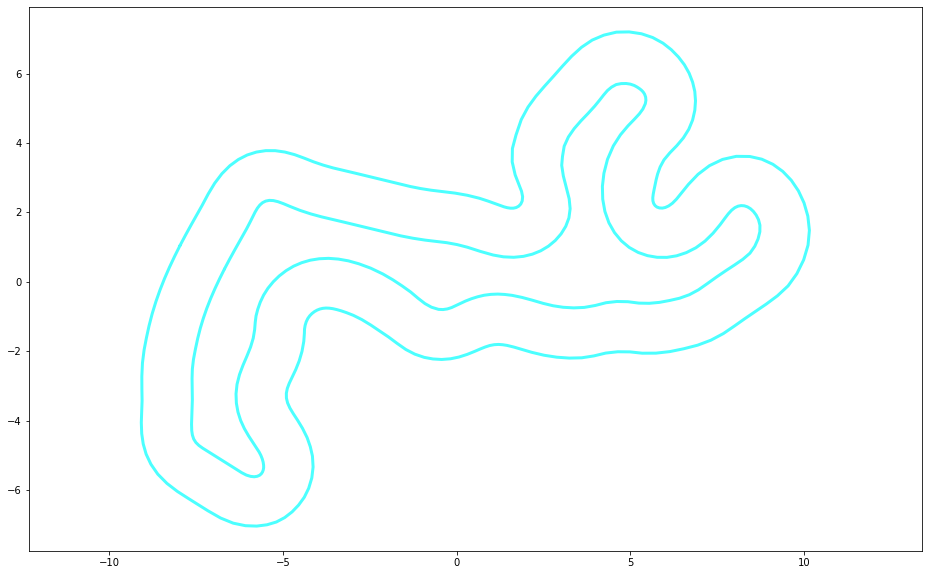

In [19]:
def plot_coords(ax, ob):                                                        
    x, y = ob.xy                                                                
    ax.plot(x, y, '*', color='#999999', zorder=1)                               
                                                                                
def plot_bounds(ax, ob):                                                        
    x, y = zip(*list((p.x, p.y) for p in ob.boundary))                          
    ax.plot(x, y, '.', color='#000000', zorder=1)                               
                                                                                
def plot_line(ax, ob):                                                          
    x, y = ob.xy                                                                
    ax.plot(x, y, color='cyan', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

def plot_line2(ax, ob):                                                          
    x, y = ob.xy                                                                
    ax.plot(x, y, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
                     
    
def print_border(ax, waypoints, inner_border_waypoints, outer_border_waypoints):
    line = LineString(waypoints)                                                
    #plot_coords(ax, line)                                                       
    #plot_line(ax, line)                                                         
                                                                                
    line = LineString(inner_border_waypoints)                                   
    #plot_coords(ax, line)                                                       
    plot_line(ax, line)                                                         
                                                                                
    line = LineString(outer_border_waypoints)                                   
    #plot_coords(ax, line)                                                       
    plot_line(ax, line)     

fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='white')
plt.axis('equal')
print_border(ax, center_line, inner_border, outer_border)

# Also print new border
#print_border(ax, center_line, inner_border_new, outer_border_new)

plot_line(ax, LineString(racing_track[:,0:2]))
plot_line2(ax, LineString(racing_track_new))


plot_coords(ax, LineString(objects_location))
#plot_coords(ax, LineString(o2))
#plot_coords(ax, LineString(o3))
plot_points(ax, center_line)


In [20]:
max(time_to_prev)

0.15392293445019875

In [21]:
# Now we have list with columns (x,y,speed,distance,time)
racing_track_everything = []
for i in range(len(racing_track)):
    racing_track_everything.append([racing_track[i][0],
                                    racing_track[i][1],
                                    velocity[i],
                                    time_to_prev[i]
                                    #, 
                                    #outer_border_new[i][0],
                                    #outer_border_new[i][1],
                                    #inner_border_new[i][0],
                                    #inner_border_new[i][1],
                                   # min(velocity),
                                  #  max(time_to_prev)
                                   ]
                                  )
# Round to 5 decimals
racing_track_everything = np.around(racing_track_everything, 5).tolist()

In [22]:
from datetime import datetime

now = datetime.now()
prefix = '%s-%s' % (TRACK_NAME, now.strftime('%Y-%m-%d-%H%M%S'))

# Write to txt file
with open(f'optimals_newest_{prefix}.txt', 'w') as f:
    f.write("[")
    for line in racing_track_everything:
        f.write("%s" % line)
        if line != racing_track_everything[-1]:
            f.write(",\n")
    f.write("]")

# Part 2: Calculate Optimal Action Space

In [23]:
# Calculate the radius for every point of the racing_track
radius = []
for i in range(len(racing_track)):
    indexes = circle_indexes(racing_track, i, add_index_1=-1, add_index_2=1) # CHANGE BACK? 1;2
    coords = [racing_track[indexes[0]],
              racing_track[indexes[1]], racing_track[indexes[2]]]
    radius.append(circle_radius(coords))

# Calculate curve direction
left_curve = []
for i in range(len(racing_track)):
    indexes = circle_indexes(racing_track, i, add_index_1=-1, add_index_2=1)
    coords = [racing_track[indexes[1]],
              racing_track[indexes[0]], racing_track[indexes[2]]]
    left_curve.append(is_left_curve(coords))

# Calculate radius with + and - for direction (+ is left, - is right)
radius_direction = []
for i in range(len(racing_track)):
    radius_with_direction = radius[i]
    if left_curve[i] == False:
        radius_with_direction *= -1
    radius_direction.append(radius_with_direction)

# Calculate steering with + and -
dist_wheels_front_back = 0.165 # meters
steering = []
for i in range(len(racing_track)):
    steer = math.degrees(math.asin(dist_wheels_front_back/radius_direction[i]))
    steering.append(steer)
    
# Merge relevant lists into dataframe
all_actions = pd.DataFrame({"velocity":velocity,
                            "steering":steering})

In [24]:
min(radius)

0.5224025688216634

Text(0.5, 1.0, 'With lookahead: 5')

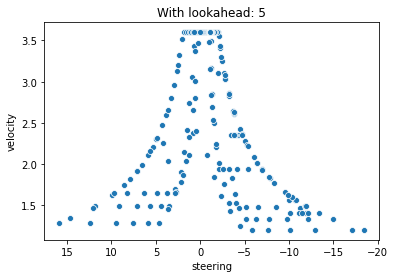

In [25]:
# Visualize action space
ax = sns.scatterplot(data=all_actions, x="steering", y="velocity")
ax.invert_xaxis()
ax.set_title(f"With lookahead: {LOOK_AHEAD_POINTS}")

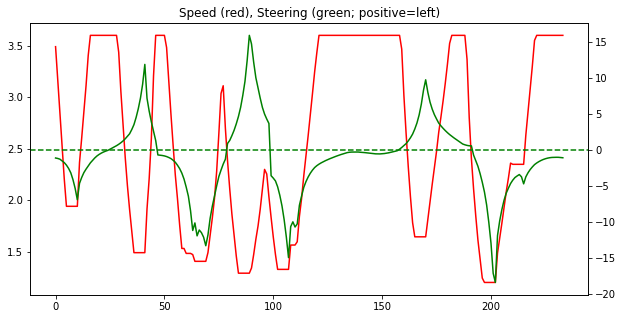

In [26]:
# Visualize all actions
plt.figure(figsize=(10, 5))
sns.lineplot(data=all_actions["velocity"], color="r")
ax2 = plt.twinx()
sns.lineplot(data=all_actions["steering"], color="g", ax=ax2)
plt.axhline(0, ls='--', color="g")
a = plt.title("Speed (red), Steering (green; positive=left)")

#### Calculate Action Space with K-Means and Resampling each point with normal distribution

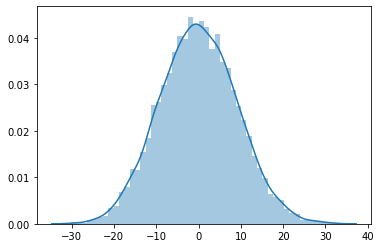

In [27]:
# Steering: Find standard deviation so that probability of >10 degrees steering is 5%
steering_sd = -15 / stats.norm.ppf(0.05)
steering_sd
sns.distplot(np.random.normal(0,steering_sd,10000))

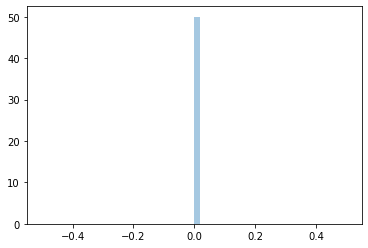

In [28]:
# Velocity: Find standard deviation so that probability of >0.25m/s deviation is 0%
# Note: Here, probability is set to 0%, so no noise regarding velocity
velocity_sd = -0.25 / stats.norm.ppf(0.00)
velocity_sd
sns.distplot(np.random.normal(0,velocity_sd,10000))

In [29]:
all_actions_norm = all_actions.copy()

all_actions_norm_len = len(all_actions_norm)
resample_size = 20000

# Add gaussian noise to action space
for i in range(all_actions_norm_len):
    v_true = all_actions_norm.iloc[i]["velocity"]
    s_true = all_actions_norm.iloc[i]["steering"]
    v_norm = np.random.normal(loc=v_true, scale=velocity_sd, size=resample_size)
    s_norm = np.random.normal(loc=s_true, scale=steering_sd, size=resample_size)
    vs_norm = pd.DataFrame(np.column_stack([v_norm,s_norm]), columns=["velocity","steering"])
    all_actions_norm = pd.concat([all_actions_norm,vs_norm], axis=0, ignore_index=True)
    
# Take out actions with max speed, so that they are not affected by gaussian noise
# We do this because there are disproportionally many points with max speed, so 
# K-Means will focus too much on these
all_actions_norm = all_actions_norm[all_actions_norm["velocity"] < MAX_SPEED]
    
# Add initial actions to action space (to make clustering more focused on initial actions)
add_n_initial_actions = int(resample_size / 8)
add_initial_actions = pd.DataFrame()
for i in range(add_n_initial_actions):
    add_initial_actions = pd.concat([add_initial_actions,all_actions], axis=0, ignore_index=True)
all_actions_norm = pd.concat([all_actions_norm,add_initial_actions], axis=0, ignore_index=True)


# Display actions shape
all_actions_norm.shape

(3745158, 2)

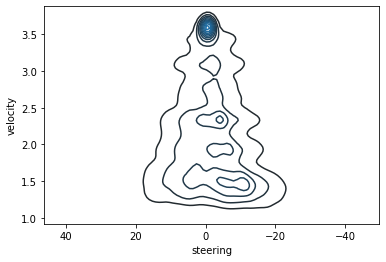

In [30]:
all_actions_norm_less = all_actions_norm.sample(frac=0.01).reset_index(drop=True) # sample bc less compute time
ax = sns.kdeplot(data=all_actions_norm_less["steering"],data2=all_actions_norm_less["velocity"])
ax.invert_xaxis()

In [31]:
X = all_actions_norm

# Calculate action space with KMeans

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans

# Rescale data with minmax
minmax_scaler = MinMaxScaler()
X_minmax = pd.DataFrame(minmax_scaler.fit_transform(X), 
                                           columns=["velocity","steering"])

# KMeans
# remove 2 actions from KMeans so that low speed & high steering actions can be manually included
#n_clusters = 10-2
#n_clusters = 15-2
n_clusters = 21-2
model = MiniBatchKMeans(n_clusters=n_clusters).fit(X_minmax)

# Centroids (interpretable)
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()
X_minmax_fit = minmax_scaler.fit(X)
X_centroids = pd.DataFrame(X_minmax_fit.inverse_transform(model.cluster_centers_), 
                                   columns=["velocity","steering"])

# Add 2 manual actions
# Reason: When car starts new episode, it does not start on or direction of racing line, so 
# it cannot steer enough to get on racing line
manual_actions = pd.DataFrame({"velocity":[MIN_SPEED,MIN_SPEED],"steering":[30,-30]})
X_centroids = pd.concat([X_centroids,manual_actions], ignore_index=True)

action_space_e = X_centroids.copy()

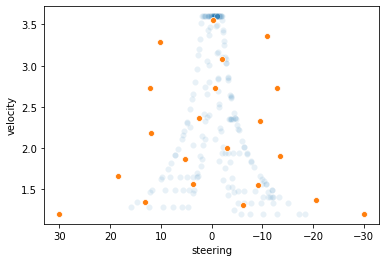

In [32]:
ax = sns.scatterplot(data=all_actions, x="steering", y="velocity", alpha=.1)
ax = sns.scatterplot(data=action_space_e, x="steering", y="velocity")
ax.invert_xaxis()

*Note: Action space can be different every time it is computed because of randome resampling with gaussian noise and also because of the random seed with K-Means. Therefore, try out multiple iterations until you are happy with the result*

#### Output as JSON format

In [33]:
import json

# Output JSON format
action_space_for_json = action_space_e[["steering","velocity"]].copy()
action_space_for_json.sort_values(by=['steering'], axis=0, inplace=True)
action_space_for_json = action_space_for_json.reset_index(drop=True)

action_space_for_json = action_space_for_json.round(4)
action_space_for_json.columns = ["steering_angle","speed"]
action_space_for_json["index"] = action_space_for_json.index
json_text = action_space_for_json.to_json(orient="records", lines=False, indent=4)

json_text = json.dumps(json.loads(json_text), indent=4)  

#json_text
action_space_for_json

,steering_angle,speed,index
0,-30.0000,1.2000,0
1,-20.6774,1.3671,1
2,-13.4135,1.8974,2
3,-12.9139,2.7271,3
4,-10.9303,3.3548,4
5,-9.5977,2.3256,5
6,-9.0786,1.5554,6
7,-6.2499,1.3059,7
8,-3.0160,2.0062,8
9,-2.0685,3.0869,9


In [34]:
from datetime import datetime

now = datetime.now()
prefix = '%s-%s' % (TRACK_NAME, now.strftime('%Y-%m-%d-%H%M%S'))

with open(f'AS21_newest_{prefix}.txt', 'w') as f:
    f.write(json_text)